In [209]:
import pandas as pd
import numpy as np
import datetime
#!pip install imblearn
import shap
import imblearn
from sklearn.inspection import permutation_importance
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [210]:
data = pd.read_csv("../data/hotel_bookings.csv")
data['less_than_seven_days'] = np.where((data['stays_in_weekend_nights'] + data['stays_in_week_nights']) < 7, '1', '0')
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

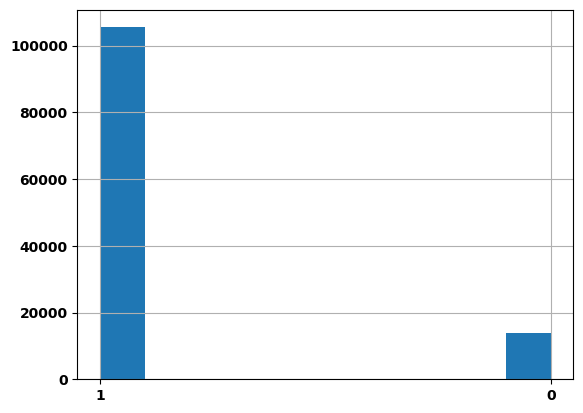

In [211]:
data['less_than_seven_days'].hist()

<AxesSubplot:>

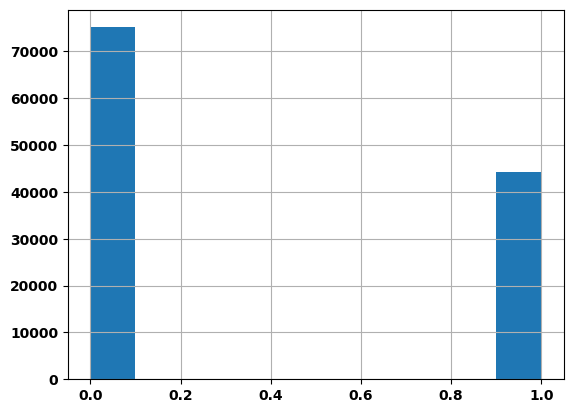

In [212]:
data['is_canceled'].hist()

<AxesSubplot:>

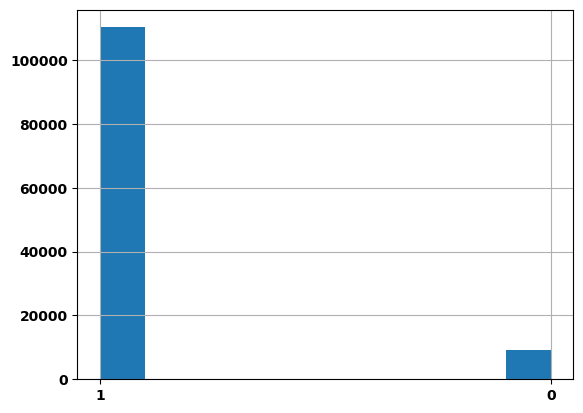

In [213]:
# variable to predict creation - 2'nd approach
# when column is_canceled is 1, it means that customer stayed less than 7 days, so y variable called 'less_than_seven_days'
# should be updated
data['less_than_seven_days'] = np.where(data['is_canceled'] == 1, '1', data['less_than_seven_days'])
data['less_than_seven_days'].hist()

In [214]:
# add public holidays (can be extended in a future)
holidays = {
    'Date': ['2024-01-01', '2024-04-25', '2024-05-01', '2024-06-10', '2024-08-15', 
             '2024-10-05', '2024-11-01', '2024-12-01', '2024-12-08', '2024-12-25'],
    'Holiday': ['New Year', 'Freedom Day', 'Labour Day', 'National Day', 'Assumption of Mary',
                'Republic Day', 'All Saints Day', 'Independence Day', 'Immaculate Conception', 'Christmas Day']
}
holidays_df = pd.DataFrame(holidays)
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
holidays_df['Week_Number'] = holidays_df['Date'].dt.isocalendar().week

# get week number of specific Holiday in a year
holidays_df['Week_Number']

0     1
1    17
2    18
3    24
4    33
5    40
6    44
7    48
8    49
9    52
Name: Week_Number, dtype: UInt32

<AxesSubplot:>

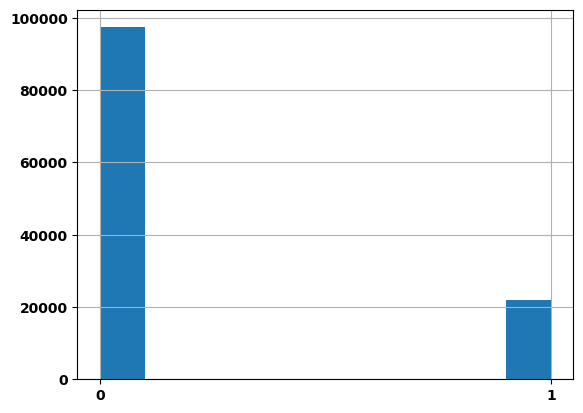

In [215]:
# we can create more complitated rules for designing 'is_arrival_week_near_holiday' variable. For example, if holiday is 
# in Saturday, 'is_arrival_week_near_holiday' can be 1 for the current and next week
data['is_arrival_week_near_holiday'] = np.where(data["arrival_date_week_number"].isin(list(holidays_df['Week_Number'])), "1", "0")
data['is_arrival_week_near_holiday'].hist()
# ~19% of planned bookings next to the holidays - quite a lot!

In [216]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,less_than_seven_days,is_arrival_week_near_holiday
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,1,0


array([[<AxesSubplot:title={'center':'is_canceled'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'arrival_date_year'}>,
        <AxesSubplot:title={'center':'arrival_date_week_number'}>],
       [<AxesSubplot:title={'center':'arrival_date_day_of_month'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>,
        <AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>,
        <AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>],
       [<AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>,
        <AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>],
       [<AxesSubplot:title={'center':'days_in_waiting_list'}>,


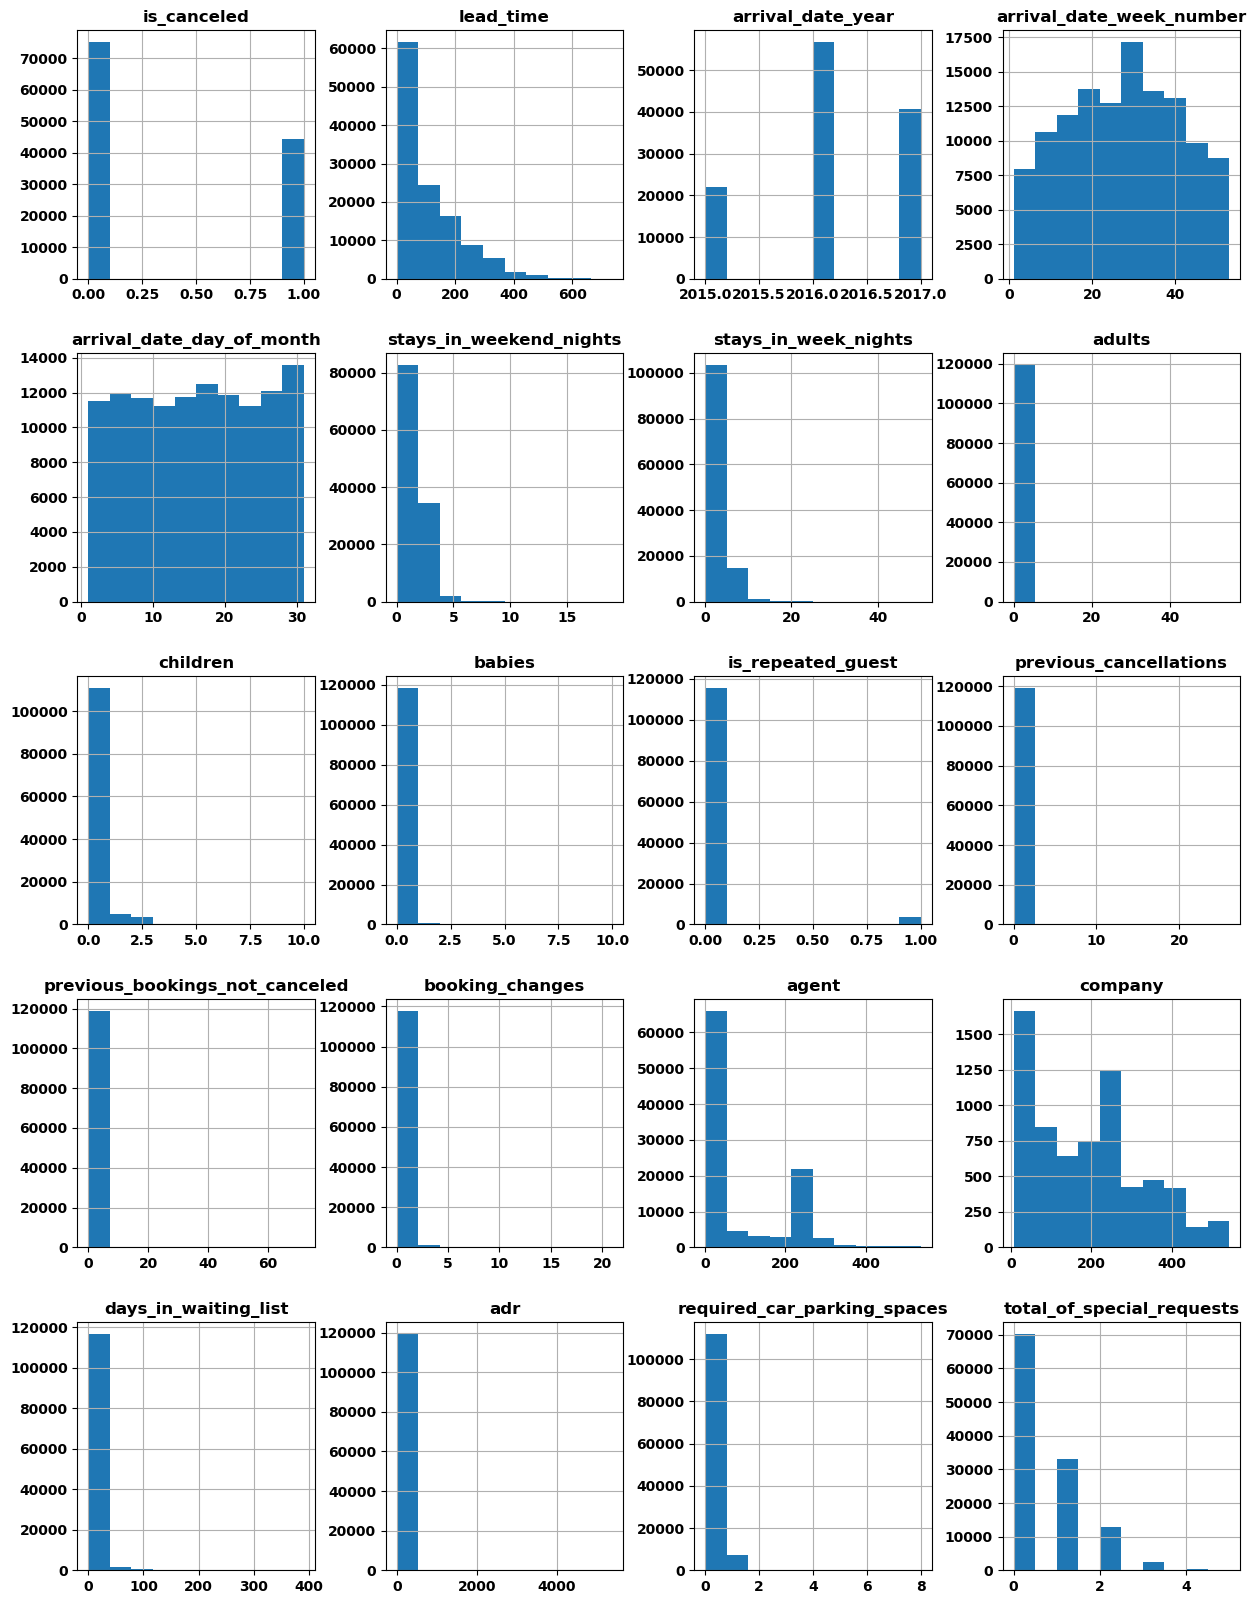

In [217]:
data.hist(figsize=(15, 20))

In [218]:
pd.DataFrame({'Null Number' : data.isna().sum(), 'Percentage Null' : (data.isna().sum()) / (data.shape[0]) * (100)})

,Null Number,Percentage Null
hotel,0,0.000000
is_canceled,0,0.000000
lead_time,0,0.000000
arrival_date_year,0,0.000000
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
arrival_date_day_of_month,0,0.000000
stays_in_weekend_nights,0,0.000000
stays_in_week_nights,0,0.000000
adults,0,0.000000


In [219]:
data.fillna(0, inplace = True)

In [220]:
guests_per_country = data['country'].value_counts(normalize=True).mul(100).round(2)
guests_per_country.columns = ['country', 'country percentage']
guests_per_country.head(30)

PRT    40.70
GBR    10.16
FRA     8.72
ESP     7.18
DEU     6.10
ITA     3.15
IRL     2.83
BEL     1.96
BRA     1.86
NLD     1.76
USA     1.76
CHE     1.45
CN      1.07
AUT     1.06
SWE     0.86
CHN     0.84
POL     0.77
ISR     0.56
RUS     0.53
NOR     0.51
ROU     0.42
0       0.41
FIN     0.37
DNK     0.36
AUS     0.36
AGO     0.30
LUX     0.24
MAR     0.22
TUR     0.21
HUN     0.19
Name: country, dtype: float64

In [221]:
# List of conditions - that columns can be created in a more 'complicated way' from business side of view,
# for example US clients are only 1.76%, but maybe they stay longer (and spend more money) than 40.7%  clients from Portugal
# and it would be 
# good to create a separate group for the US clients. Here, separate levels for top 5 countries, rest is 'OTHER'
conditions = [
      (data['country'] == "PRT")
    , (data['country'] == "GBR")
    , (data['country'] == "FRA")
    , (data['country'] == "ESP")
    , (data['country'] == "DEU")

]
choices  = [
      "PRT"
    , "GBR"
    , "FRA"
    , "ESP"
    , "DEU"
]
data["country_group"] = np.select(conditions, choices, "OTHER")

In [222]:
guests_per_country_group = data['country_group'].value_counts(normalize=True).mul(100).round(2)
guests_per_country_group.columns = ['country', 'country percentage']
guests_per_country_group.head(7)
# we can see OTHER group is relative big

PRT      40.70
OTHER    27.14
GBR      10.16
FRA       8.72
ESP       7.18
DEU       6.10
Name: country_group, dtype: float64

In [223]:
# drop rows - exception - if chidren, babies and adults is 0 it means sth is wrong with reservation
filter_value = (data.children == 0) & (data.adults == 0) & (data.babies == 0)
data = data[~filter_value]
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,less_than_seven_days,is_arrival_week_near_holiday,country_group
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0,PRT
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,0,PRT
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,0,GBR
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,0,GBR
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,0,GBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,Transient,96.14,0,0,Check-Out,2017-09-06,0,0,OTHER
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,Transient,225.43,0,2,Check-Out,2017-09-07,0,0,FRA
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,Transient,157.71,0,4,Check-Out,2017-09-07,0,0,DEU
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,Transient,104.40,0,0,Check-Out,2017-09-07,0,0,GBR


In [224]:
# drop columns which are not going to be included in the model creation
useless_cols = ['is_canceled', 'days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']

data.drop(useless_cols, axis = 1, inplace = True)

In [225]:
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])

data['month'] = data['reservation_status_date'].dt.month
data['day'] = data['reservation_status_date'].dt.day

In [226]:
data.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)
data

,hotel,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,less_than_seven_days,is_arrival_week_near_holiday,country_group,month,day
0,Resort Hotel,342,27,1,0,0,2,0.0,0,BB,...,0.0,Transient,0.00,0,0,1,0,PRT,7,1
1,Resort Hotel,737,27,1,0,0,2,0.0,0,BB,...,0.0,Transient,0.00,0,0,1,0,PRT,7,1
2,Resort Hotel,7,27,1,0,1,1,0.0,0,BB,...,0.0,Transient,75.00,0,0,1,0,GBR,7,2
3,Resort Hotel,13,27,1,0,1,1,0.0,0,BB,...,0.0,Transient,75.00,0,0,1,0,GBR,7,2
4,Resort Hotel,14,27,1,0,2,2,0.0,0,BB,...,0.0,Transient,98.00,0,1,1,0,GBR,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,23,35,30,2,5,2,0.0,0,BB,...,0.0,Transient,96.14,0,0,0,0,OTHER,9,6
119386,City Hotel,102,35,31,2,5,3,0.0,0,BB,...,0.0,Transient,225.43,0,2,0,0,FRA,9,7
119387,City Hotel,34,35,31,2,5,2,0.0,0,BB,...,0.0,Transient,157.71,0,4,0,0,DEU,9,7
119388,City Hotel,109,35,31,2,5,2,0.0,0,BB,...,0.0,Transient,104.40,0,0,0,0,GBR,9,7


In [227]:
# select categorical columns
categorical_cols = [col for col in data.columns if data[col].dtype == 'O']
print(categorical_cols)
categorical_df = data[categorical_cols]

categorical_df['meal'] = categorical_df['meal'].map({'FB' : 1, 'BB': 2, 'SC': 3, 'HB': 4, 'Undefined': 5})

categorical_df['hotel'] = categorical_df['hotel'].map({'City Hotel' : 1, 'Resort Hotel' : 2})

categorical_df['market_segment'] = categorical_df['market_segment'].map({'Corporate': 1, 'Direct': 2, 'Online TA': 3, 'Offline TA/TO': 4,
                                                           'Complementary': 5, 'Groups': 6, 'Aviation': 7, 'Undefined': 8})

categorical_df['country_group'] = categorical_df['country_group'].map({'PRT': 1, 'GBR': 2, 'DEU': 3, 'FRA': 4,
                                                                       'ESP': 5, 'OTHER': 6})

categorical_df['distribution_channel'] = categorical_df['distribution_channel'].map({'Corporate': 1, 'Direct': 2, 'TA/TO': 3, 'Undefined': 4,
                                                                       'GDS': 5})

categorical_df['reserved_room_type'] = categorical_df['reserved_room_type'].map({'C': 1, 'A': 2, 'D': 3, 'E': 4, 'G': 5, 'F': 6, 'H': 7,
                                                                   'L':8, 'B': 9})

categorical_df['deposit_type'] = categorical_df['deposit_type'].map({'No Deposit': 1, 'Refundable': 2, 'Non Refund': 3})

categorical_df['customer_type'] = categorical_df['customer_type'].map({'Group': 1, 'Contract': 2, 'Transient-Party': 3, 'Transient': 4})

categorical_df.head()

['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type', 'less_than_seven_days', 'is_arrival_week_near_holiday', 'country_group']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,less_than_seven_days,is_arrival_week_near_holiday,country_group
0,2,2,2,2,1,1,4,1,0,1
1,2,2,2,2,1,1,4,1,0,1
2,2,2,2,2,2,1,4,1,0,2
3,2,2,1,1,2,1,4,1,0,2
4,2,2,3,3,2,1,4,1,0,2


In [228]:
data['month'] = pd.Categorical(data.month)
data['day'] = pd.Categorical(data.day)

numerical_df = data.drop(columns = categorical_cols, axis = 1)
numerical_df.drop(['month','day'] , axis = 1, inplace = True)

numerical_df.head()

X = pd.concat([numerical_df, categorical_df], axis = 1)
X.drop(['less_than_seven_days', 'stays_in_weekend_nights', 'stays_in_week_nights'] , axis = 1, inplace = True)

y = data['less_than_seven_days']


In [229]:
### 2.0 Data modelling
# stratified sampling should be used, but now for testing purposes I'm using 'random sampling'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,...,total_of_special_requests,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,is_arrival_week_near_holiday,country_group
92550,118,27,1,2,0.0,0,0,0,0,9.0,...,1,1,2,3,3,2,1,3,0,6
70427,123,24,16,2,0.0,0,0,0,0,9.0,...,0,1,2,3,3,4,1,4,1,4
43349,74,38,18,2,0.0,0,0,0,0,6.0,...,0,1,4,4,3,2,1,3,0,1
85067,2,11,7,1,0.0,0,0,0,0,0.0,...,1,1,2,2,2,2,1,3,0,1
101146,41,45,3,2,0.0,0,0,0,0,28.0,...,1,1,2,4,3,2,1,4,0,4


In [230]:
# put more focus on class imbalance
random_forest_model = RandomForestClassifier(random_state=0,  class_weight='balanced_subsample')
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
conf_random_forest = confusion_matrix(y_test, y_pred_random_forest)
random_forest_report = classification_report(y_test, y_pred_random_forest)

print(f"Confusion Matrix: \n{conf_random_forest}")
print(f"Classification Report: \n{random_forest_report}")

Confusion Matrix: 
[[ 1141  1113]
 [  199 27350]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.51      0.63      2254
           1       0.96      0.99      0.98     27549

    accuracy                           0.96     29803
   macro avg       0.91      0.75      0.81     29803
weighted avg       0.95      0.96      0.95     29803



In [231]:
from imblearn.ensemble import BalancedRandomForestClassifier
imbalanced_random_forest_model = BalancedRandomForestClassifier(n_estimators=100)
imbalanced_random_forest_model.fit(X_train, y_train)
y_pred_imbalanced_random_forest = imbalanced_random_forest_model.predict(X_test)
conf_imbalanced_random_forest = confusion_matrix(y_test, y_pred_imbalanced_random_forest)
random_imbalanced_forest_report = classification_report(y_test, y_pred_imbalanced_random_forest)

print(f"Confusion Matrix: \n{conf_imbalanced_random_forest}")
print(f"Classification Report: \n{random_imbalanced_forest_report}")

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.


Confusion Matrix: 
[[ 1948   306]
 [ 4017 23532]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.33      0.86      0.47      2254
           1       0.99      0.85      0.92     27549

    accuracy                           0.85     29803
   macro avg       0.66      0.86      0.69     29803
weighted avg       0.94      0.85      0.88     29803



In [232]:
feature_names = [f"feature {i}" for i in range(X_test.shape[1])]
#import time
start_time = time.time()
result = permutation_importance(
    random_forest_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

Elapsed time to compute the importances: 84.305 seconds


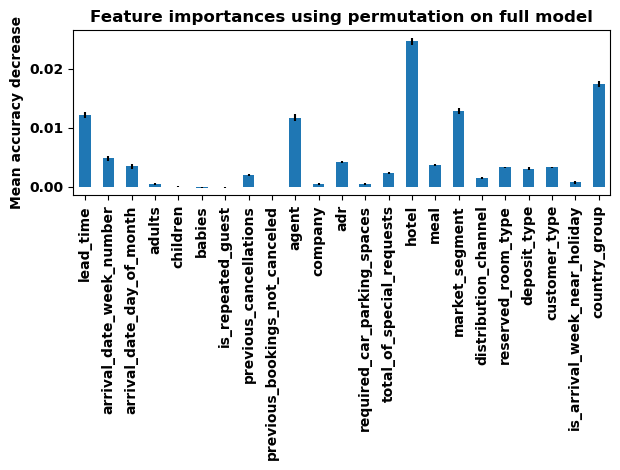

In [233]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [156]:
#!pip install h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 34 mins
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 29 days
H2O_cluster_name:,H2O_from_python_adam_dropol
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.070 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [203]:
X_train['less_than_seven_days'] = y_train
X_train.head()
X_test['less_than_seven_days'] = y_test

train_x = h2o.H2OFrame(X_train)
test_x = h2o.H2OFrame(X_test)

print(train_x.nrow)
print(test_x.nrow)
train_x, valid_x = train_x.split_frame(ratios = [.8], seed = 1234)
print(train_x.nrow)
print(valid_x.nrow)
print(test_x.nrow)

x = train_x.columns
y = "less_than_seven_days"
x.remove(y)


train_x[y] = train_x[y].asfactor()
valid_x[y] = valid_x[y].asfactor()
test_x[y] = test_x[y].asfactor()



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
89407
29803
71502
17905
29803


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Hyper-Parameter Search Summary: ordered by increasing logloss
    balance_classes    model_ids                                                    logloss
--  -----------------  -----------------------------------------------------------  ---------
    true               Grid_GBM_py_1_sid_a82a_model_python_1708342859277_2_model_1  0.771012


In [204]:
from h2o.automl import H2OAutoML
# Run AutoML for 15 models
aml = H2OAutoML(max_models=15, seed=1, stopping_metric = "AUCPR", sort_metric = "AUCPR", balance_classes=True, 
               stopping_rounds = 2)
aml.train(x=x, y=y, training_frame=train_x, validation_frame = valid_x)

AutoML progress: |█
18:51:44.843: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
18:51:44.867: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/15
# GBM base models (used / total),3/8
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),2/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [170]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)  

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_3_20240219_145855,0.993561,0.935186,0.137296,0.261562,0.193956,0.0376191
StackedEnsemble_BestOfFamily_1_AutoML_3_20240219_145855,0.993052,0.931455,0.141564,0.28031,0.196594,0.0386492
GBM_grid_1_AutoML_3_20240219_145855_model_4,0.992748,0.928427,0.171056,0.274174,0.224379,0.050346
GBM_grid_1_AutoML_3_20240219_145855_model_1,0.992653,0.926936,0.17607,0.273822,0.227319,0.0516739
GBM_4_AutoML_3_20240219_145855,0.99265,0.925932,0.166694,0.284076,0.220266,0.0485171
GBM_1_AutoML_3_20240219_145855,0.992391,0.925483,0.165072,0.2823,0.218601,0.0477865
GBM_3_AutoML_3_20240219_145855,0.992055,0.920645,0.171012,0.296096,0.223045,0.049749
DRF_1_AutoML_3_20240219_145855,0.991892,0.924184,0.19104,0.286622,0.214841,0.0461567
GBM_2_AutoML_3_20240219_145855,0.991592,0.916279,0.173902,0.31974,0.224774,0.0505232
XRT_1_AutoML_3_20240219_145855,0.991279,0.91481,0.202202,0.305466,0.242263,0.0586916


In [165]:
preds = aml.leader.predict(test_x)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


89407


In [171]:
preds_df = preds.as_data_frame()['predict']

converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).


In [172]:
list(preds['predict'])
conf_automl = confusion_matrix(y_test,  preds_df.astype(str))
report_automl = classification_report(y_test,  preds_df.astype(str))

print(f"Confusion Matrix: \n{conf_automl}")
print(f"Classification Report: \n{report_automl}")

Confusion Matrix: 
[[ 1061  1216]
 [  223 27303]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.47      0.60      2277
           1       0.96      0.99      0.97     27526

    accuracy                           0.95     29803
   macro avg       0.89      0.73      0.79     29803
weighted avg       0.95      0.95      0.95     29803



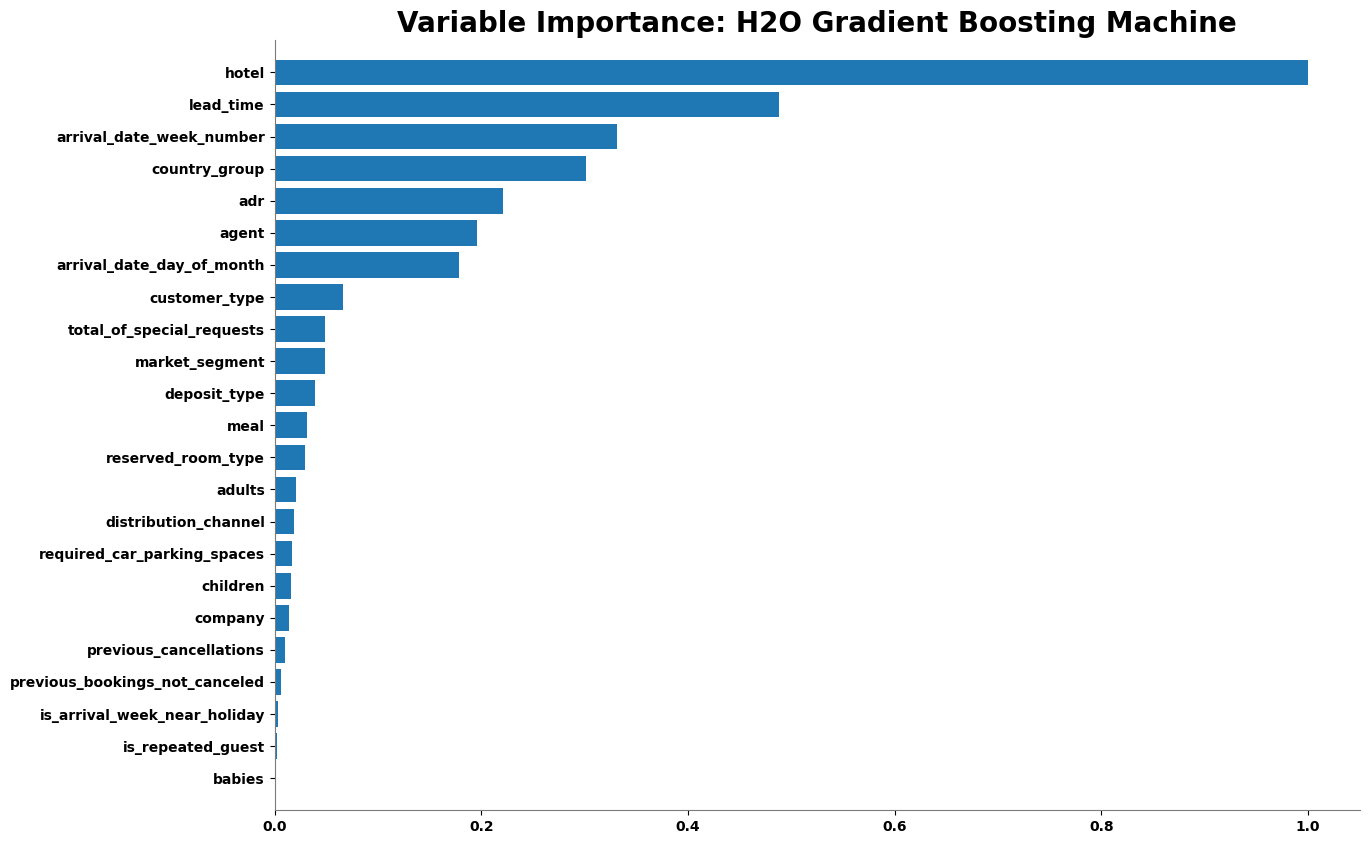

<Figure size 640x480 with 0 Axes>

In [174]:
#aml.model('GBM_grid_1_AutoML_1_20240219_130606_model_4')
m = h2o.get_model("GBM_grid_1_AutoML_3_20240219_145855_model_4")
m.varimp_plot(15)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- less_than_seven_days
Feature names must be in the same order as they were in fit.



ValueError: X has 24 features, but RandomForestClassifier is expecting 23 features as input.

In [ ]:
#1. Create a model which explains (predicts) if the number of days spent in a hotel is higher or equal to 7 days 
# (sum of stays_in_weekend_nights and stays_in_week_nights).
#2. Justify variables and algorithms used. Give arguments that will convince both a technical (data scientist) 
# and a non-technical person that your solution is sensible.
#3. Assess the quality of your model. Would you recommend using the solution to explain extended stays in hotels?

# 1. Done
# 2. Comments: 
# 2.1
# I removed 'year' to make solution independent from the year and to make solution ready to forecast for years in the 
# future - for years not inlcluded in the dataset. I assumed, that we can omit 'year' variable - it means that I do not 
# checked, if we have any time-dependent pattern in booking time - maybe those two hotels are getting more shorter bookings 
# year by year because of any reason, e.g. any third hotel, weather condtions.
# 2.2
# First algorithm used is Random Forest - simple classification algorithm which can be used as a benchmark. Second model 
# is also based on Random Forest, but with different implementation. Third approach uses automl tool - h2o -
# many models and also stacking of those models. 

# 2.3 
# Justification for technical audience: I used proper models and I also took class imbalance into account. 
# But still there is a problem with prediction of the 0 class. Variables which are used are easy to get from the 
# booking system (needs to be checked), so any of those 3 models can be used based on them. For sure, error analysis 
# should be done - cases not properly classified should be checked.
# I will focus on the first Random Forest model: it should not be launched in production, because of error in 
# predicting 0 class. There is a need to discuss with business what is the most important for them, and optimize 
# modelling technique for agreed KPI.
# Stratified train val test split should be also done in a future.
# Permutation variable importance taken into account for interpretability, Shapley values can be done in a future.
# 
# Justification for the non technical audience: solution uses data taken from our databases, so it's simple to make predictions
# using that data. We should agree on a 'lead time' constraint - how much time we have to make predictions. For example if,
# lead time = 1, we have less than 1 day to deliver predictions. Also we must agree about costs of errors. Maybe predicting 
# booking shorter than 7 days correctly is cheaper than predicting more than 7 days incorrectly.

# 3.
# As mentioned above, I need to know specific KPI business is interested and then we can access whether models are good enough
# to be used. In general, I can see that two first models are giving different predictions for 0 class. One has high recall,
# and another big precision. 
